Things to do
- Get AIF datasets
- Train on positive pairs for fairness
- Generate synthetic testing pairs
- Evaluate fairness
- Code up a booster

In [20]:
!pip install git+https://github.com/clabrugere/pytorch-scarf.git
!pip install aif360
!pip install tqdm

  Cloning https://github.com/clabrugere/pytorch-scarf.git to c:\users\mxian\appdata\local\temp\pip-req-build-k6awn12a
  Resolved https://github.com/clabrugere/pytorch-scarf.git to commit 3cc5b0641fdd1acedb9784f84e3cab68cf6015a3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/clabrugere/pytorch-scarf.git 'C:\Users\mxian\AppData\Local\Temp\pip-req-build-k6awn12a'


     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 320.0 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 599.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0:00:00


In [25]:
# INstall CUDA
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
     - -------------------------------------- 0.2/4.9 MB 5.6 MB/s eta 0:00:01
     ---- ----------------------------------- 0.5/4.9 MB 6.4 MB/s eta 0:00:01
     ------- -------------------------------- 0.9/4.9 MB 7.3 MB/s eta 0:00:01
     ---------- ----------------------------- 1.3/4.9 MB 7.3 MB/s eta 0:00:01
     ------------- -------------------------- 1.6/4.9 MB 7.3 MB/s eta 0:00:01
     ---------------- ----------------------- 2.0/4.9 MB 7.7 MB/s eta 0:00:01
     ------------------- -------------------- 2.4/4.9 MB 7.7 MB/s eta 0:00:01
     ---------------------- ----------------- 2.8/4.9 MB 7.6 MB/s eta 0:00:01
     ------------------------ --------------- 3.1/4.9 MB 7.5 MB/s eta 0:00:01
     --------------------------- ------------ 3.4/4.9 MB 7.6 MB/s eta 0:00:01
     ------------------------------- -------- 3.8/4.9 MB 7.6 MB/s eta 0:00:01
     -------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scarf 0.1 requires torch==2.2, but you have torch 2.2.2+cu118 which is incompatible.



     ---------- ----------------------------- 0.7/2.7 GB 9.4 MB/s eta 0:03:34
     ---------- ----------------------------- 0.7/2.7 GB 9.4 MB/s eta 0:03:34
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.2 MB/s eta 0:03:37
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB/s eta 0:03:40
     ---------- ----------------------------- 0.7/2.7 GB 9.1 MB

In [26]:
# Imports
from scarf.loss import NTXent
from scarf.model import SCARF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
import tqdm
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [27]:
# Hyperparameters & Helper Functions
def dataset_embeddings(model, loader, device):
    embeddings = []

    for x in tqdm(loader):
        x = x.to(device)
        embeddings.append(model.get_embeddings(x))

    embeddings = torch.cat(embeddings).cpu().numpy()

    return embeddings


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


batch_size = 128
epochs = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1234
fix_seed(seed)

In [23]:
class SCARFDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    @property
    def features_low(self):
        return self.data.min(axis=0)

    @property
    def features_high(self):
        return self.data.max(axis=0)

    @property
    def shape(self):
        return self.data.shape

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [24]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, stratify=target, random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
train_ds = SCARFDataset(
    train_data.to_numpy(), train_target.to_numpy(), columns=train_data.columns
)
test_ds = SCARFDataset(
    test_data.to_numpy(), test_data.to_numpy(), columns=test_data.columns
)

In [15]:
# Model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        emb_anchor, emb_positive = model(x)

        loss = criterion(emb_anchor, emb_positive)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")

epoch 100/5000 - loss: 20.2634
epoch 200/5000 - loss: 19.9532
epoch 300/5000 - loss: 19.8690
epoch 400/5000 - loss: 19.8741
epoch 500/5000 - loss: 19.7725
epoch 600/5000 - loss: 19.6611
epoch 700/5000 - loss: 19.6262
epoch 800/5000 - loss: 19.6896
epoch 900/5000 - loss: 19.6970
epoch 1000/5000 - loss: 19.6806
epoch 1100/5000 - loss: 19.6380
epoch 1200/5000 - loss: 19.6791
epoch 1300/5000 - loss: 19.6882
epoch 1400/5000 - loss: 19.6546


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

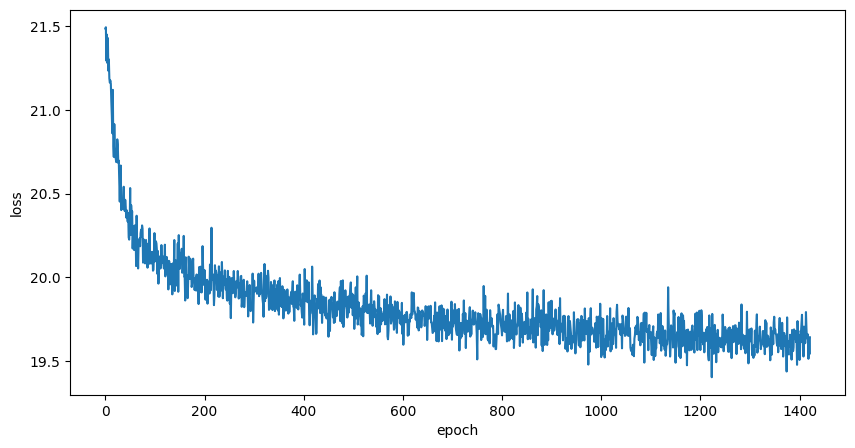

In [16]:
# Plot loss history

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")